# Nontemporal task: Polynomial prediction

RMSE (prediction) = 0.003543


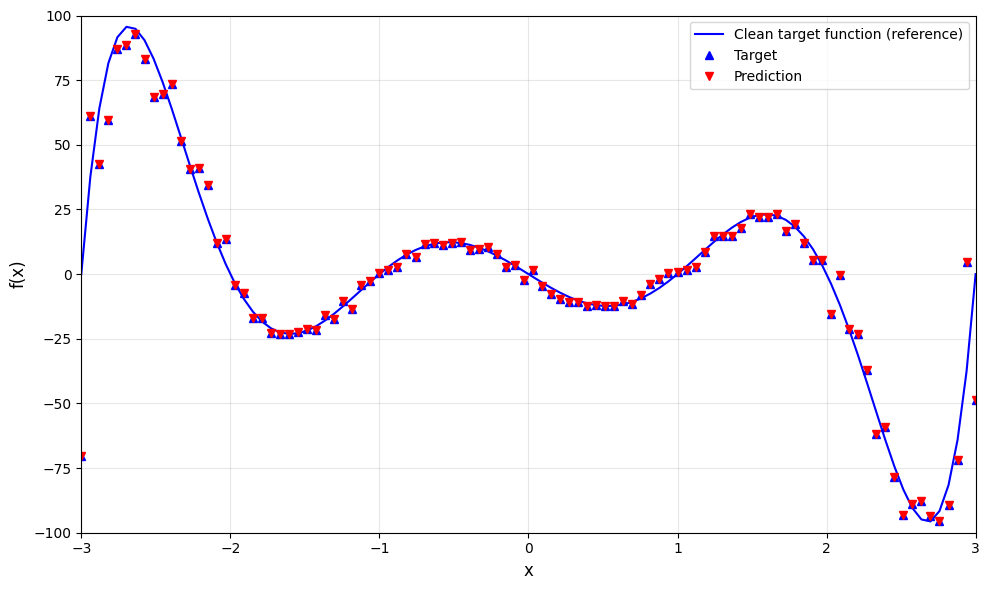

In [133]:
import numpy as np
import matplotlib.pyplot as plt

def logistic_map(r, P, x0=0.95, noise=0.0, seed=None):
    np.random.seed(seed)
    x = np.zeros(P)
    cur = x0
    for i in range(P):
        cur = r * cur * (1.0 - cur)
        x[i] = cur
    return x

def poly(x):
    return (x - 3) * (x - 2) * (x - 1) * x * (x + 1) * (x + 2) * (x + 3)

def build_reservoir_nontemporal(u, P, amin, amax, umin, umax, omega0=0.95, seed=None):
    L = len(u)
    R = np.zeros((P, L))
    for i in range(L):
        a_i = amin + (amax - amin) * (u[i] - umin) / (umax - umin)
        R[:, i] = logistic_map(a_i, P, x0=omega0, noise=0, seed=seed)
    return R

def train_rc(u_train, v_train, P, amin, amax, umin, umax, omega0=0.95, seed=None):
    R = build_reservoir_nontemporal(u_train, P, amin, amax, umin, umax, omega0, seed)
    W = v_train @ np.linalg.pinv(R, rcond=1e-12)
    return W

def predict_rc(W, u_pred, P, amin, amax, umin, umax, omega0=0.95, seed=None):
    R = build_reservoir_nontemporal(u_pred, P, amin, amax, umin, umax, omega0, seed)
    V = W @ R
    return V

# Parameters
P = 20
amin, amax = 3.8, 3.9
umin, umax = -3.0, 3.0
omega0 = 0.95
delta = 0.1
L = 100
seed = 19

# Training data (random samples as "few available samples")
x_train = np.random.uniform(umin, umax, L)
u_train = x_train + np.random.uniform(-delta, delta, L)
v_train = poly(u_train)

# Train
W = train_rc(u_train, v_train, P, amin, amax, umin, umax, omega0, seed)

# Prediction data (uniform)
x_pred = np.linspace(umin, umax, L)
u_pred = x_pred + np.random.uniform(-delta, delta, L)
V_pred = predict_rc(W, u_pred, P, amin, amax, umin, umax, omega0, seed)

# Target for prediction (f at the noisy input)
target = poly(u_pred)

# Performance
rmse = np.sqrt(np.mean((target - V_pred) ** 2))
print(f"RMSE (prediction) = {rmse:.6f}")

# PLOT
plt.figure(figsize=(10, 6))
plt.plot(x_pred, poly(x_pred), 'b-', lw=1.5, label='Clean target function (reference)')
plt.plot(x_pred, target, 'b^', label='Target')
plt.plot(x_pred, V_pred, 'rv', label='Prediction')
plt.xlim(-3, 3)
plt.ylim(-100, 100)
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Temporal task: Continuous system prediction

In [93]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def logistic_map(r, P, x0=0.95, noise=0.0, seed=None):
    np.random.seed(seed)
    x = np.zeros(P)
    cur = x0
    for i in range(P):
        cur = r * cur * (1.0 - cur)
        if noise > 0:
            cur += np.random.uniform(-noise, noise)
        x[i] = cur
    return x

def rossler_system(t_end=500.0, dt=0.1, x0=[0.1, 0.2, 0.3], noise=0.0, seed=None):
    """
    Integrate Rössler equations and return time + x, y, z
    """
    np.random.seed(seed)
    t = np.arange(0, t_end, dt)
    def eqs(s, _):
        x, y, z = s
        return [-y - z, x + 0.2*y, 0.2 + z*(x - 5.7)]
    xyz = odeint(eqs, x0, t)
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    if noise > 0:
        x += np.random.uniform(-noise, noise, len(t))
    return t, x, y, z

def lorenz_system(t_end=100.0, dt=0.01, x0=[0.1, 1.0, 1.05], noise=0.0, seed=None):
    """
    Continuous Lorenz system (dx/dt, dy/dt, dz/dt)
    Returns: t, x, y, z
    """
    np.random.seed(seed)
    t = np.arange(0, t_end, dt)
    def eqs(s, _):
        x, y, z = s
        sigma, rho, beta = 10.0, 28.0, 8/3
        return [sigma*(y - x), x*(rho - z) - y, x*y - beta*z]
    xyz = odeint(eqs, x0, t, atol=1e-10, rtol=1e-10)
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    if noise > 0:
        x += np.random.uniform(-noise, noise, len(t))
    return t, x, y, z

def build_reservoir_matrix(u, P, m, amin, amax, umin, umax, omega0, seed=None):
    """
    Build R matrix: each column = Z_i = [g1*Y_{i-m+1}, ..., gm*Y_i]
    Size: (m*P, L)
    """
    L = len(u)
    R = np.zeros((m * P, L))
    Y = np.zeros((L, P))  # Precompute all Y_i

    # Precompute Y_i for all inputs
    for i in range(L):
        a_i = amin + (amax - amin) * (u[i] - umin) / (umax - umin)
        Y[i] = logistic_map(a_i, P, omega0, noise=0, seed=seed)

    # Weights: g1 to g_{m-1} ~ Uniform[0,1], gm = 1.0
    #np.random.seed(seed)
    #g = np.append(np.random.rand(m - 1), 1.0)
    g = np.linspace(0, 1, m + 1)[1:]

    # Build each column Z_i
    for i in range(L):
        col_blocks = []
        for j in range(m):
            past_idx = i - m + j + 1  # Y_{i-m+1}, ..., Y_i
            if past_idx >= 0:
                col_blocks.append(g[j] * Y[past_idx])
            else:
                col_blocks.append(np.zeros(P))  # pad
        R[:, i] = np.concatenate(col_blocks)

    return R, Y, g  # return g for prediction reuse

def train_rc(u_train, v_train, P, m, amin, amax, umin, umax, omega0=0.95, seed=None):
    """
    Train: W = v_train @ pinv(R)
    """
    R, _, g = build_reservoir_matrix(u_train, P, m, amin, amax, umin, umax, omega0, seed)
    # Moore-Penrose with tiny ridge for stability
    W = v_train @ np.linalg.pinv(R, rcond=1e-12) # (1, L) @ (L, mP) -> (1, mP)
    return W, g

# Closed-Loop Prediction (Autonomous)
def predict_rc(W, u_init, P, m, amin, amax, umin, umax, steps, omega0=0.95, g=None, seed=None):
    """
    Start from last m values of u_init, predict 'steps' future points.
    Feedback: predicted value becomes new input.
    """
    if len(u_init) < m:
        raise ValueError("u_init must have at least m elements")
    if g is None:
            raise ValueError("g must be provided from training")
    
    mem = u_init[-m:].copy()  # Initial memory: last m points
    pred = np.zeros(steps)
    
    for k in range(steps):
        col = []
        for j in range(m):
            ui = mem[j]  # mem[0]=oldest, mem[m-1]=newest
            a_i = amin + (amax - amin) * (ui - umin) / (umax - umin)
            Yk = logistic_map(a_i, P, omega0, noise=0, seed=seed)
            col.append(g[j] * Yk)
        Z = np.concatenate(col)
        pred[k] = W @ Z
        # Update memory
        mem = np.roll(mem, -1)
        mem[-1] = pred[k]
    
    return pred

RMSE (validation horizon) = 2.658857


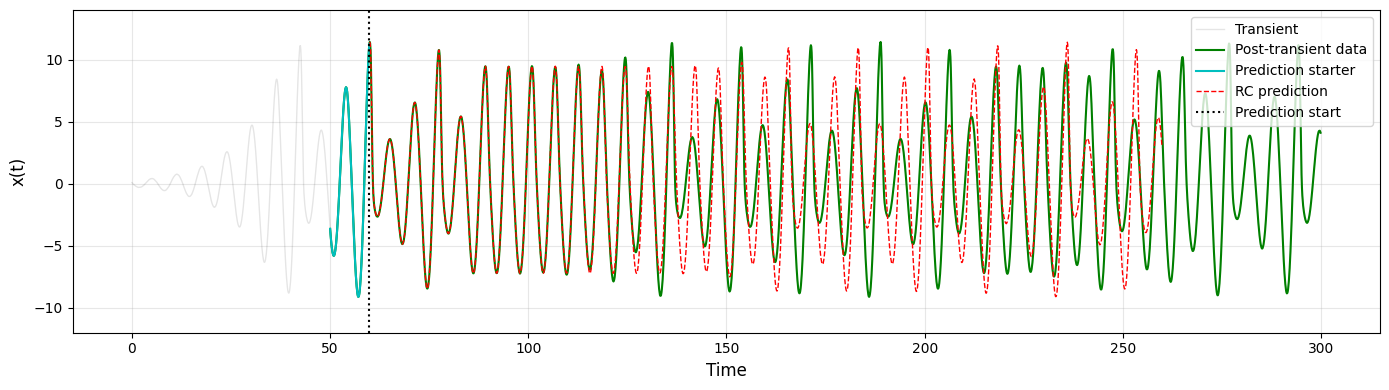

In [66]:
# Parameters
P = 20
m = 100
amin, amax = 3.8, 3.9
umin, umax = -10.0, 12.0
omega0 = 0.95

noise = 0.01
transient = 500
predict_steps = 2000  # How many future points to generate

length = 3000  # Data length in terms of data points
dt = 0.1
time = length * dt

seed = 19

# Data generation and preparation
t_full, x_full, y, z = rossler_system(t_end=time, dt=dt, noise=noise, seed=seed)
# After cutting transient
x = x_full[transient:]
t = t_full[transient:]

# Add tiny dither if no noise
if noise == 0.0:
    x += 1e-8 * np.random.randn(len(x))

# 1. Training segment – use ALL post-transient data
u_train = x[:-1]
v_train = x[1:]

# 2. Prediction starts from the FIRST m points of training
p_init = u_train[:m]
t_init = t[:m]

# 3. True future (validation) – next predict_steps points after p_init
p_valid = u_train[m : m + predict_steps]
t_valid = t[m : m + predict_steps]

# Train RC
W, g = train_rc(u_train, v_train, P, m, amin, amax, umin, umax, omega0, seed=seed)

# Predicted output
p_pred = predict_rc(W, p_init, P, m, amin, amax, umin, umax, steps=predict_steps, omega0=omega0, g=g, seed=seed) # length = predict_steps
t_pred = np.arange(t_init[-1] + dt, t_init[-1] + dt * (predict_steps + 1), dt)[:predict_steps]  # length = predict_steps

# Performance: RMSE on the validation horizon
rmse = np.sqrt(np.mean((p_valid - p_pred) ** 2))
print(f"RMSE (validation horizon) = {rmse:.6f}")

# PLOT
plt.figure(figsize=(14, 4))
plt.plot(t_full, x_full, 'k-', lw=1.0, alpha=0.1, label='Transient')
plt.plot(t, x, 'g-', lw=1.5, alpha=1, label='Post-transient data')
plt.plot(t_init, p_init, 'c-', lw=1.5, alpha=1, label='Prediction starter')
plt.plot(t_pred, p_pred, 'r--', lw=1, alpha=1, label='RC prediction')
plt.axvline(t_init[-1], color='k', linestyle=':', linewidth=1.5, label='Prediction start')

#plt.xlim(350, 400)
plt.ylim(-12, 14)

# Layout
plt.xlabel('Time', fontsize=12)
plt.ylabel('x(t)', fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

RMSE (validation horizon) = 2.462467


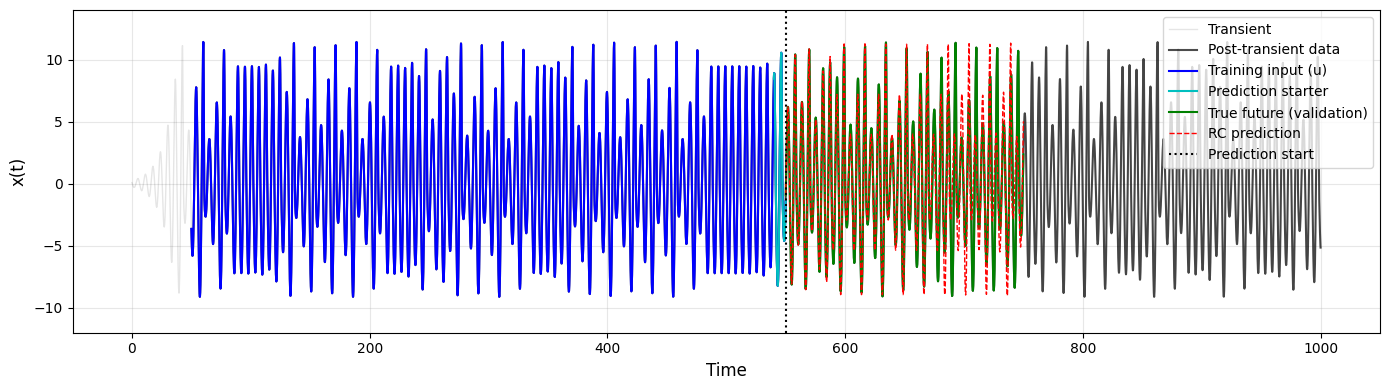

In [67]:
# Parameters
P = 30
m = 100
amin, amax = 3.8, 3.9
umin, umax = -10.0, 12.0
omega0 = 0.95

noise = 0.01
transient = 500
predict_steps = 2000  # How many future points to generate

length = 10000  # Data length in terms of data points
dt = 0.1
time = length * dt

seed = 19

# Data generation and preparation
t_full, x_full, y, z = rossler_system(t_end=time, dt=dt, noise=noise, seed=seed)
# After cutting transient
x = x_full[transient:]
t = t_full[transient:]

# 1. Training segment (e.g., first 1000 points after transient)
train_end = 5000
u_train = x[:train_end]           # x[0] to x[999]
v_train = x[1:train_end+1]        # x[1] to x[1000]

# 2. Prediction starts after training
p_init = u_train[-m:]                     # last m points of training → initial memory
t_init = t[:train_end][-m:]               # t[0 … 999] → last m points → t[900:1000]

# 3. True future (validation) – next predict_steps points
p_valid = x[train_end : train_end + predict_steps]      # x[1000 : 1000+predict_steps]
t_valid = t[train_end : train_end + predict_steps]      # same times

# Train RC
W, g = train_rc(u_train, v_train, P, m, amin, amax, umin, umax, omega0, seed=seed)

# Predicted output
p_pred = predict_rc(W, p_init, P, m, amin, amax, umin, umax, steps=predict_steps, omega0=omega0, g=g, seed=seed) # length = predict_steps
t_pred = np.arange(t_init[-1] + dt, t_init[-1] + dt * (predict_steps + 1), dt)[:predict_steps]  # length = predict_steps

# Performance: RMSE on the validation horizon
rmse = np.sqrt(np.mean((p_valid - p_pred) ** 2))
print(f"RMSE (validation horizon) = {rmse:.6f}")

# PLOT
plt.figure(figsize=(14, 4))
plt.plot(t_full, x_full, 'k-', lw=1.0, alpha=0.1, label='Transient')
plt.plot(t, x, 'k-', lw=1.5, alpha=0.7, label='Post-transient data')
plt.plot(t[:train_end], u_train, 'b-', lw=1.5, alpha=1, label='Training input (u)')
plt.plot(t_init, p_init, 'c-', lw=1.5, alpha=1, label='Prediction starter')
plt.plot(t_valid, p_valid, 'g-', lw=1.5, alpha=1, label='True future (validation)')
plt.plot(t_pred, p_pred, 'r--', lw=1, alpha=1, label='RC prediction')
plt.axvline(t_init[-1], color='k', linestyle=':', linewidth=1.5, label='Prediction start')

#plt.xlim(350, 400)
plt.ylim(-12, 14)

# Layout
plt.xlabel('Time', fontsize=12)
plt.ylabel('x(t)', fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

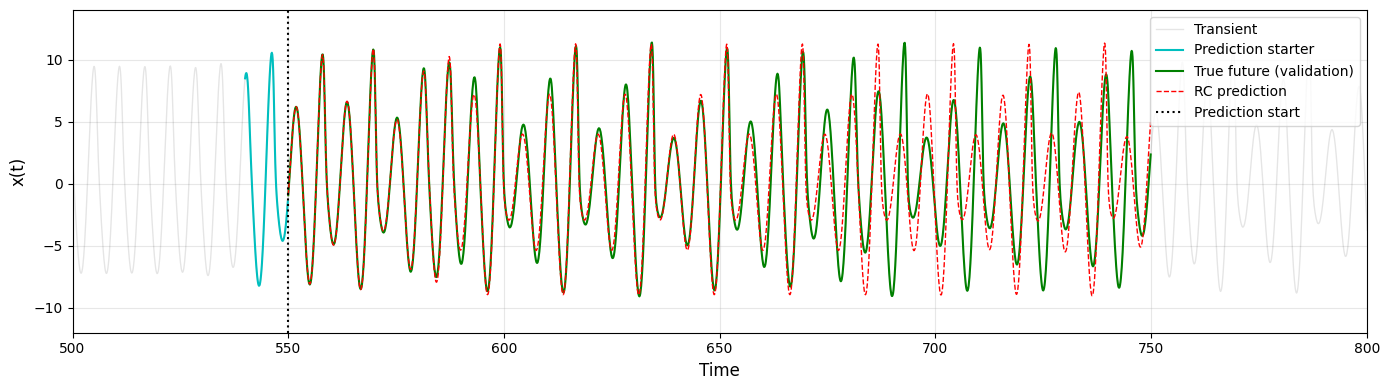

In [68]:
# PLOT
plt.figure(figsize=(14, 4))
plt.plot(t_full, x_full, 'k-', lw=1.0, alpha=0.1, label='Transient')
#plt.plot(t, x, 'k-', lw=1.5, alpha=0.7, label='Post-transient data')
#plt.plot(t[:train_end], u_train, 'b-', lw=1.5, alpha=1, label='Training input (u)')
plt.plot(t_init, p_init, 'c-', lw=1.5, alpha=1, label='Prediction starter')
plt.plot(t_valid, p_valid, 'g-', lw=1.5, alpha=1, label='True future (validation)')
plt.plot(t_pred, p_pred, 'r--', lw=1, alpha=1, label='RC prediction')
plt.axvline(t_init[-1], color='k', linestyle=':', linewidth=1.5, label='Prediction start')

plt.xlim(500, 800)
plt.ylim(-12, 14)

# Layout
plt.xlabel('Time', fontsize=12)
plt.ylabel('x(t)', fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()